<a href="https://colab.research.google.com/github/adspacheco/classificacao-fraturas/blob/main/analises_classificacao_fraturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtenção dos Dados

In [123]:
%%capture
!wget https://github.com/adspacheco/classificacao-fraturas/raw/main/dataset/dataset.zip
!unzip /content/dataset.zip

# Bibliotecas e Constantes


In [113]:
import os
import random
import os
from PIL import Image
import matplotlib.pyplot as plt

base_path = '/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x'

# Exploração da Estrutura dos Arquivos

In [114]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

'Avulsion fracture'	'Greenstick fracture'  'Longitudinal fracture'	'Spiral Fracture'
'Comminuted fracture'	'Hairline Fracture'    'Oblique fracture'
'Fracture Dislocation'	'Impacted fracture'    'Pathological fracture'


Cada tipo de fratura possui um diretório único.

In [115]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture

Test  Train


O tipo de fratura "Avulsion fracture" tem uma pasta test/train associada.

In [116]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture/Test

000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg
05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a3e1e25a0cac6f45.jpg
1b62e6fbfbc5a2f70c6af413189cfc82_jpg.rf.2761e933cc6d206308877cccaf0642b2.jpg
1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg
220px-Avulsion_fracture_of_tibial_tuberosity2C_annotated_jpg.rf.aac7ac1f6ad2f7a822ee729f39b750af.jpg
31446tn_jpg.rf.fd1466bd9c9a7d604dc3e782f87b84d6.jpg
389382_jpg.rf.8cb98ee798766a2d3f6a76279ba5d0d9.jpg
5c7fec45769db28bdd107336f19004336689a4fb804b37af3096741f2879ff02_jumbo_jpeg.rf.68a4d14a09ed5baf1f8e1c1957ee5a01.jpg
60683ca7a8a5848feda86d15_acl-avulsion-fracture-1_jpg.rf.17e17d797643e92164cc9825dc530399.jpg
9896089d1b31b0ba0158dc33122899_jumbo_jpeg.rf.d5e6b871460129728d2506e55476d496.jpg
9dcddacffaff8689cc1e9cedbe76a5_jumbo_jpeg.rf.7259a238161cf03dca23a3dd5369e0b1.jpg
avuls

Dentro do diretório Test do tipo de fratura "Avulsion fracture" tem o arquivo da imagem, todas com extensão .jpg

# Validação da Estrutura dos Arquivos
- Toda pasta (tipo de fratura) tem train/test associada
- Todos arquivos (imagens das fraturas) são .jpg
- Visualização dos arquivos se é de fato imagem de fraturas

Todos os diretórios possuem 'Train' e 'Test', e todos os arquivos são .jpg, alguns arquivos de exemplo:

Exemplos de arquivos:
/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Hairline Fracture/Train/A320567_1_En_5_Fig3_HTML_jpg.rf.94ac07af6d69b71d28929cda494a7ea8.jpg


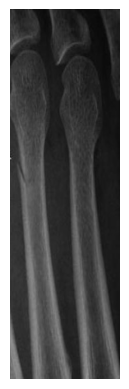

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Fracture Dislocation/Train/pediatric20elbow20dislocation20and20mediadyle20fracture_g.rf.7fd0217ef2ea1200be525743c4330f90.jpg


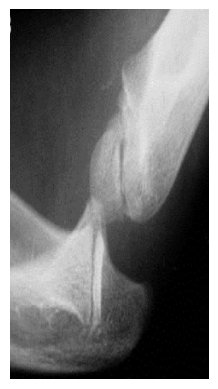

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Fracture Dislocation/Train/lightbox_ff8e0dd027ac11eb92a5b7c2605fc013-figure-1_png.rf.e7f6c87caf004b92b9c429cfcb073456.jpg


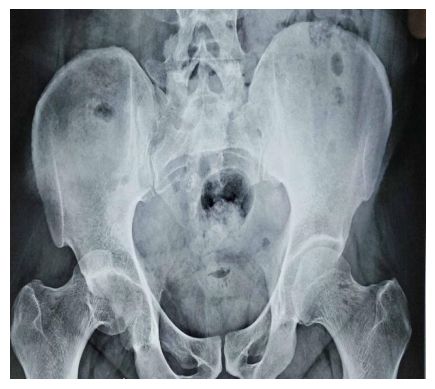

In [117]:
def validate_and_list_files(base_path):
    all_dirs = os.listdir(base_path)
    all_have_train_test = True
    all_files_jpg = True
    all_files = []

    for dir_name in all_dirs:
        dir_path = os.path.join(base_path, dir_name)
        if os.path.isdir(dir_path):
            train_path = os.path.join(dir_path, 'Train')
            test_path = os.path.join(dir_path, 'Test')
            if os.path.exists(train_path) and os.path.exists(test_path):
                if not (validate_jpg_files(train_path) and validate_jpg_files(test_path)):
                    all_files_jpg = False
                all_files.extend([os.path.join(train_path, file) for file in list_files(train_path)])
                all_files.extend([os.path.join(test_path, file) for file in list_files(test_path)])
            else:
                all_have_train_test = False

    if all_have_train_test and all_files_jpg:
        print("Todos os diretórios possuem 'Train' e 'Test', e todos os arquivos são .jpg, alguns arquivos de exemplo:")
        examples = random.sample(all_files, min(len(all_files), 3))
        print("\nExemplos de arquivos:")
        for example in examples:
            print(example)
            show_image(example)
    else:
        print("Nem todos os diretórios possuem 'Train' e 'Test', ou nem todos os arquivos são .jpg.")

def list_files(dir_path):
    return [file for file in os.listdir(dir_path) if file.lower().endswith('.jpg')]

def validate_jpg_files(dir_path):
    files = os.listdir(dir_path)
    for file in files:
        if not file.lower().endswith('.jpg'):
            return False
    return True

def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

validate_and_list_files(base_path)

# Quantidade de arquivos

In [118]:
def count_files_and_calculate_percentages(base_path, train_name='Train', test_name='Test'):
    all_dirs = os.listdir(base_path)
    counts = {}

    for dir_name in all_dirs:
        dir_path = os.path.join(base_path, dir_name)
        if os.path.isdir(dir_path):
            train_path = os.path.join(dir_path, train_name)
            test_path = os.path.join(dir_path, test_name)
            if os.path.exists(train_path) and os.path.exists(test_path):
                train_count = count_files(train_path)
                test_count = count_files(test_path)
                total_count = train_count + test_count
                counts[dir_name] = {'Train': train_count, 'Test': test_count, 'Total': total_count}

    for dir_name, count in counts.items():
        train_percentage = (count['Train'] / count['Total']) * 100 if count['Total'] > 0 else 0
        test_percentage = (count['Test'] / count['Total']) * 100 if count['Total'] > 0 else 0
        print(f"Diretório: {dir_name} - Total: {count['Total']}")
        print(f"  Train files: {count['Train']} ({train_percentage:.2f}%)")
        print(f"  Test files: {count['Test']} ({test_percentage:.2f}%)")

    total_train_files = sum(count['Train'] for count in counts.values())
    total_test_files = sum(count['Test'] for count in counts.values())
    total_files = total_train_files + total_test_files

    print("\nResumo:")
    if total_files > 0:
        print(f"  Total Train: {total_train_files} ({(total_train_files / total_files) * 100:.2f}%)")
        print(f"  Total Test: {total_test_files} ({(total_test_files / total_files) * 100:.2f}%)")
    else:
        print("Nenhum arquivo encontrado.")

    return counts

def count_files(dir_path):
    return len([file for file in os.listdir(dir_path) if file.lower().endswith('.jpg')])

initial_counts = count_files_and_calculate_percentages(base_path)

Diretório: Hairline Fracture - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)
Diretório: Pathological fracture - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: Impacted fracture - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: Longitudinal fracture - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: Avulsion fracture - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)
Diretório: Spiral Fracture - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)
Diretório: Comminuted fracture - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)
Diretório: Fracture Dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: Greenstick fracture - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: Oblique fracture - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)

Resumo:
  Total Train: 989 (87.60%)
  

# Padronização

In [119]:
def generate_new_dir_name(subdir):
    if subdir.lower() == "fracture dislocation":
        return "fracture_dislocation"
    return subdir.lower().replace(" fracture", "")

def rename_directories_and_files(base_path):
    old_to_new_dir_names = {}
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            new_subdir_name = generate_new_dir_name(subdir)
            new_subdir_path = os.path.join(base_path, new_subdir_name)
            old_to_new_dir_names[subdir] = new_subdir_name

            if new_subdir_name != subdir:
                os.rename(subdir_path, new_subdir_path)
            else:
                new_subdir_path = subdir_path

            for folder in ['Train', 'Test']:
                folder_path = os.path.join(new_subdir_path, folder)
                if os.path.exists(folder_path):
                    new_folder_path = os.path.join(new_subdir_path, folder.lower())
                    if folder.lower() != folder:
                        os.rename(folder_path, new_folder_path)
                    else:
                        new_folder_path = folder_path

            file_counter = 1
            for folder in ['train', 'test']:
                folder_path = os.path.join(new_subdir_path, folder)
                if os.path.exists(folder_path):
                    for root, _, files in os.walk(folder_path):
                        for file in files:
                            file_ext = os.path.splitext(file)[1]
                            new_file_name = f"{new_subdir_name}_{str(file_counter).zfill(3)}{file_ext}"
                            new_file_path = os.path.join(root, new_file_name)

                            os.rename(os.path.join(root, file), new_file_path)

                            file_counter += 1

    return old_to_new_dir_names

old_to_new_dir_names = rename_directories_and_files(base_path)

print("\nContagem de arquivos depois da padronização:")
new_counts = count_files_and_calculate_percentages(base_path, train_name='train', test_name='test')

def validate_counts(initial_counts, new_counts, name_mapping):
    for old_dir_name, new_dir_name in name_mapping.items():
        initial_train_count = initial_counts[old_dir_name]['Train']
        initial_test_count = initial_counts[old_dir_name]['Test']
        new_train_count = new_counts[new_dir_name]['Train']
        new_test_count = new_counts[new_dir_name]['Test']

        if initial_train_count != new_train_count or initial_test_count != new_test_count:
            print(f"\nAtenção: A quantidade de arquivos foi alterada para {new_dir_name} após a padronização.")
            return

    print("\nPadronização realizada com sucesso. A quantidade de arquivos permanece inalterada.")

validate_counts(initial_counts, new_counts, old_to_new_dir_names)


Contagem de arquivos depois da padronização:
Diretório: impacted - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: pathological - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: spiral - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)
Diretório: comminuted - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)
Diretório: oblique - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)
Diretório: avulsion - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)
Diretório: fracture_dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: longitudinal - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: greenstick - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: hairline - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)

Resumo:
  Total Train: 989 (87.60%)
  Total Test: 140 (12.40%)

Padroniza

In [120]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

avulsion    fracture_dislocation  hairline  longitudinal  pathological
comminuted  greenstick		  impacted  oblique	  spiral


In [121]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion

test  train


In [122]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion/test

avulsion_110.jpg  avulsion_113.jpg  avulsion_116.jpg  avulsion_119.jpg	avulsion_122.jpg
avulsion_111.jpg  avulsion_114.jpg  avulsion_117.jpg  avulsion_120.jpg	avulsion_123.jpg
avulsion_112.jpg  avulsion_115.jpg  avulsion_118.jpg  avulsion_121.jpg
